In [10]:
#
# Emre Alca
# University of Pennsylvania
# Created on Mon Nov 24 2025
#


In [11]:
import numpy as np
import trimesh
import tqdm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib widget

from src import spindle_state as ss

Visualization
- [ ] plot (or animate well) MTOC position and trajectory within the boundary condition
- [ ] plot (or animate well) spindle state over time
- [ ] plot cost over time

In [12]:
test_spindle_lattice = np.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0],
    [0, 0, 1],
    [0, 0, -1],
])

expected_mt_vecs = np.array([
       [ 0.5,  0. ,  0. ],
       [-1.5,  0. ,  0. ],
       [-0.5,  1. ,  0. ],
       [-0.5, -1. ,  0. ],
       [-0.5,  0. ,  1. ],
       [-0.5,  0. , -1. ]])

test_spindle_state = np.array([1, 1, 3, 3, 1, 1])

test_spindle = ss.Spindle(np.array([0.5, 0, 0]), test_spindle_state, test_spindle_lattice)

In [13]:
# -- time series test -- 

# --- stabilizing test --- 
test_spindle.add_microtubules([2,3])
initial_pos = np.array([0.5, 0, 0])
test_spindle.set_mtoc_pos(initial_pos)

stabilizing_mtoc_pos_list = np.array([initial_pos])
num_timesteps = 10000
timestep_size = 0.1
times = np.arange(0, timestep_size * num_timesteps, timestep_size)

for i in tqdm.tqdm(range(num_timesteps)):
    new_mtoc_pos = test_spindle.mtoc_time_evolution()[0]
    test_spindle.set_mtoc_pos(new_mtoc_pos)
    stabilizing_mtoc_pos_list = np.vstack([stabilizing_mtoc_pos_list, new_mtoc_pos])

test_spindle.remove_microtubules([2,3])


100%|██████████| 10000/10000 [00:00<00:00, 31835.59it/s]


In [14]:
# --- destabilizing test ---
# -- the simulation breaks when the boundary condition is violated -- 
test_spindle.add_microtubules(np.array([0,1]))
initial_pos = np.array([0, 0.1, 0.1])
test_spindle.set_mtoc_pos(initial_pos)

destabilizing_mtoc_pos_list = np.array([initial_pos])
num_timesteps = 10000
timestep_size = 0.1
times = np.arange(0, timestep_size * num_timesteps, timestep_size)

boundary_violated = False
i = 0
# for i in tqdm.tqdm(range(num_timesteps)):
while i < num_timesteps and boundary_violated == False: 
    new_mtoc_pos, boundary_violated = test_spindle.mtoc_time_evolution()
    test_spindle.set_mtoc_pos(new_mtoc_pos)
    destabilizing_mtoc_pos_list = np.vstack([destabilizing_mtoc_pos_list, new_mtoc_pos])
    i = i + 1

test_spindle.remove_microtubules([0,1])


/opt/anaconda3/envs/spindle-simulations/lib/python3.11/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


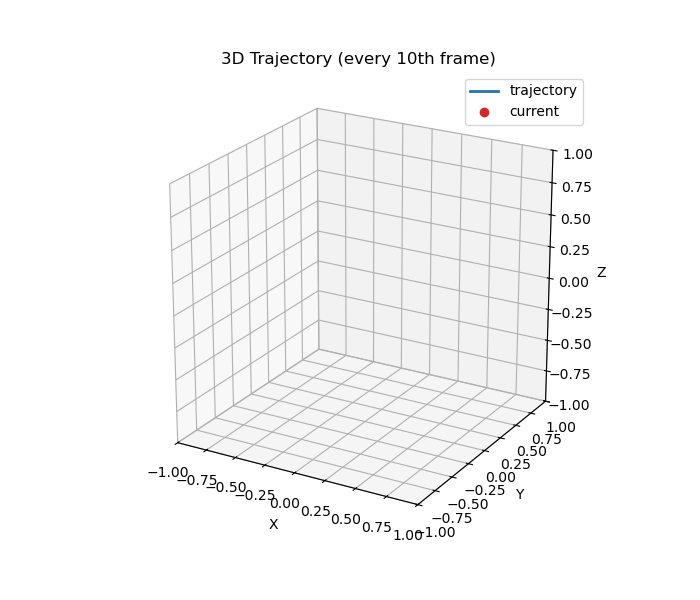

In [15]:
mtoc_pos_list = stabilizing_mtoc_pos_list

t = times
x, y, z = mtoc_pos_list[:, 0], mtoc_pos_list[:, 1], mtoc_pos_list[:, 2]
N = len(x)

# --- Subsample frames: one in every 10 timesteps ---
step = 100
frame_indices = np.arange(0, N, step)   # e.g., [0, 10, 20, ..., N-1]

# --- Figure & axes ---
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('3D Trajectory (every 10th frame)')
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')

# Fix limits for stable view
pad = 0.05
mins = mtoc_pos_list.min(axis=0)
maxs = mtoc_pos_list.max(axis=0)
span = np.maximum(maxs - mins, 1e-9)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_box_aspect([1, 1, 1])  # equal scale on all axes
ax.view_init(elev=22, azim=-60)

# Plot elements
trail, = ax.plot([], [], [], lw=2, color='tab:blue', label='trajectory')
head,  = ax.plot([], [], [], 'o', color='tab:red', markersize=6, label='current')
time_text = ax.text2D(0.02, 0.95, '', transform=ax.transAxes)

ax.legend(loc='upper right')

def init():
    trail.set_data_3d([], [], [])
    head.set_data_3d([], [], [])
    time_text.set_text('')
    return trail, head, time_text

def update(frame_idx):
    i = frame_indices[frame_idx]   # map animation frame to actual data index
    trail.set_data_3d(x[:i+1], y[:i+1], z[:i+1])
    head.set_data_3d([x[i]], [y[i]], [z[i]])
    time_text.set_text(f'Index: {i} / {N-1}')
    # Optional: rotate camera slowly
    # ax.view_init(elev=20, azim=-60 + 0.3*frame_idx)
    return trail, head, time_text

# KEEP a reference and render explicitly in the same cell
ani = FuncAnimation(fig, update, frames=len(frame_indices), init_func=init, interval=40, blit=False)

# If using %matplotlib notebook/widget:
plt.show()

# If using %matplotlib inline, prefer JSHTML:
